<a name="top" id="top"></a>

<div align="center">
    <h1>Molecular Docking via (DC-)QAOA</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <a href="https://colab.research.google.com/github/bernalde/UA_FarmaIAQC_2025/blob/main/MolecularDocking.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

# Molecular docking via DC-QAOA

Drugs often work by binding to an active site of a protein, inhibiting or activating its function for some therapeutic purpose. Finding new candidate drugs is extremely difficult. The study of molecular docking helps guide this search and involves the prediction of how strongly a certain ligand (drug) will bind to its target (usually a protein).  


## Table of Contents

1. [**Introduction**](#introduction) - Problem overview and motivation
2. [**Molecular Docking Problem Setup**](#molecular-docking-problem-setup) - Detailed problem formulation and workflow
3. [**CUDA-Q Implementation**](#cuda-q-implementation) - Quantum computing framework setup
4. [**Problem Definition**](#problem-definition) - Graph construction and parameters
   - [BIG Graph Definition](#big-graph-definition)
   - [Hamiltonian Construction](#hamiltonian-construction)
   - [Coefficient and Pauli Word Extraction](#coefficient-extraction)
5. [**Quantum Circuit Implementation**](#quantum-circuit-implementation) - QAOA and DC-QAOA kernels
   - [DC-QAOA Circuit](#dc-qaoa-circuit)
   - [Standard QAOA Circuit](#standard-qaoa-circuit)
6. [**Optimization Setup**](#optimization-setup) - Parameter initialization and optimizer configuration
   - [DC-QAOA Optimizer](#dc-qaoa-optimizer)
   - [QAOA Optimizer](#qaoa-optimizer)
7. [**Algorithm Execution**](#algorithm-execution) - Running optimization algorithms
   - [QAOA Optimization](#qaoa-optimization)
   - [DC-QAOA Optimization](#dc-qaoa-optimization)
8. [**Results Analysis**](#results-analysis) - Sampling and solution interpretation
   - [Quantum State Sampling](#quantum-state-sampling)
   - [Most Probable Solutions](#most-probable-solutions)
9. [**Performance Comparison**](#performance-comparison) - Convergence analysis and method comparison

## Key Features

- **Molecular Docking Formulation**: Complete workflow from protein-ligand structures to quantum optimization
- **Dual Algorithm Implementation**: Both standard QAOA and digitized-counteradiabatic QAOA
- **Graph-Based Encoding**: Binding Interaction Graph (BIG) representation of molecular interactions
- **Performance Analysis**: Convergence comparison and optimization trajectory visualization
- **Practical Application**: Real molecular docking problem with pharmacore interactions



One of the primary challenges to molecular docking arises from the many geometric degrees of freedom present in proteins and ligands, making it difficult to predict the optimal orientation and assess if the drug is a good candidate or not. One solution is to formulate the problem as a mathematical optimization problem where the optimal solution corresponds to the most likely ligand-protein configuration. This optimization problem can be solved on a quantum computer using methods like the Quantum Approximate Optimization Algorithm (QAOA). This tutorial demonstrates how this [paper](https://arxiv.org/pdf/2308.04098) used digitized-counteradiabatic (DC) QAOA to study molecular docking.  This tutorial assumes you have an understanding of QAOA, if not, please see the CUDA-Q MaxCut tutorial found [here](https://nvidia.github.io/cuda-quantum/latest/applications/python/qaoa.html).

The next section provides more detail on the problem setup followed by CUDA-Q implementations below.

**Reference**: 
- The overall notebook is mostly a reimplementation of the molecular docking tutorial of CUDA-Q [here](https://nvidia.github.io/cuda-quantum/latest/applications/python/digitized_counterdiabatic_qaoa.html)
- The reformulation of the problem is based on Ding et al. 2024: [Arxiv 2308.04098](https://arxiv.org/pdf/2308.04098)
- The Digitized-Counteradiabatic QAOA method is proposed by Chandarana, et al. 2022 [Phys. Rev. Res. 4, 013141](https://doi.org/10.1103/PhysRevResearch.4.013141)

In [1]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !pip install cudaq

# If the partition.png file is not there, download it
import os
if not os.path.exists("partition.png"):
    !wget https://raw.githubusercontent.com/bernalde/UA_FarmaIAQC_2025/refs/heads/main/partition.png

# If the image file docking.png is not there, download it
if not os.path.exists("docking.png"):
    !wget https://raw.githubusercontent.com/bernalde/UA_FarmaIAQC_2025/refs/heads/main/docking.png


### Setting up the Molecular Docking Problem

The figure from the [paper](https://arxiv.org/pdf/2308.04098) provides a helpful diagram for understanding the workflow.

![docking](docking.png)


There are 6 key steps:
1.  The experimental protein and ligand structures are determined and used to select pharmacores, or an important chemical group that will govern the chemical interactions.
2. Two labeled distance graphs (LAGs) of size $N$ and $M$ represent the protein and the ligand, respectively. Each node corresponds to a pharmacore and each edge weight corresponds to the distance between pharmacores.
3.  A $M*N$ node binding interaction graph (BIG) is created from the LAGs. Each node in the BIG graph corresponds to a pair of pharmacores, one from the ligand and the other from the protein. The existence of edges between nodes in the BIG graph are determined from the LAGs and correspond to interactions that can feesibly coexist. Therefore, cliques in the graph correspond to mutually possible interactions. 
4. The problem is mapped to a QAOA circuit and corresponding Hamiltonian. From there, the ground state solution is determined.
5.  The ground state will produce the maximum weighted clique which corresponds to the best (most strongly bound) orientation of the ligand and protein.
6.  The predicted docking structure is interpreted from the QAOA result and is used for further analysis.


### CUDA-Q Implementation

First, the appropriate libraries are imported and the `nvidia` backend is selected to run on GPUs if available.

In [2]:
import cudaq
from cudaq import spin
import numpy as np
import matplotlib.pyplot as plt


#Specify random seeds
np.random.seed(13)
cudaq.set_random_seed(13)


The block below defines two of the BIG data sets from the paper. The first is a smaller example, but it can be swapped with the commented out example below at your discretion. The weights are specified for each node based on the nature of the ligand and protein pharmacores represented by the node.

In [3]:
# The two graph inputs from the paper

# BIG 1

nodes = [0, 1, 2, 3, 4, 5]
qubit_num = len(nodes)
edges = [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4],
         [3, 4], [3, 5], [4, 5]]
non_edges = [
    [u, v] for u in nodes for v in nodes if u < v and [u, v] not in edges
]

print('Edges: ', edges)
print('Non-Edges: ', non_edges)

weights = [0.6686, 0.6686, 0.6686, 0.1453, 0.1453, 0.1453]
penalty = 6.0
num_layers = 3

# BIG 2 (More expensive simulation)
#nodes=[0,1,2,3,4,5,6,7]
#qubit_num=len(nodes)
#edges=[[0,1],[0,2],[0,5],[0,6],[0,7],[1,2],[1,4],[1,6],[1,7],[2,4],[2,5],[2,7],[3,4],[3,5],[3,6],\
#    [4,5],[4,6],[5,6]]
#non_edges=[[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
#print('Edges: ', edges)
#print('Non-edges: ', non_edges)
#weights=[0.6686,0.6686,0.6886,0.1091,0.0770,0.0770,0.0770,0.0770]
#penalty=8.0
#num_layers=8

Edges:  [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 5]]
Non-Edges:  [[0, 3], [1, 4], [2, 5]]


Next, the Hamiltonian is constructed: 

$$H = \frac{1}{2}\sum_{i \in V}w_i(\sigma^z_i - 1) + \frac{P}{4} \sum_{(i,j) \notin E, i \neq j} (\sigma^z_i -1)(\sigma^z_j - 1) $$


The first term concerns the vertices and the weights of the given pharmacores.  The second term is a penalty term that penalizes edges of the graph with no interactions.  The penalty $P$ is set by the user and is defined as 6 in the cell above. The function below returns the Hamiltonian as a CUDA-Q `spin_op` object.



In [4]:
# Generate the Hamiltonian
def ham_clique(penalty, nodes, weights, non_edges) -> cudaq.SpinOperator:
    """
    Generate the Hamiltonian for the clique problem.
    
    Parameters
    ----------
    penalty : float
        The penalty term for non-edges.
    nodes : list of int
        The list of nodes in the graph.
    weights : list of float
        The weights associated with the edges.
    non_edges : list of list of int
        The list of non-edges in the graph, where each non-edge is represented as a
        list of two nodes.

    Returns
    -------
    cudaq.SpinOperator
        The Hamiltonian representing the clique problem.
    
    """

    spin_ham = 0
    for wt, node in zip(weights, nodes):
        #print(wt,node)
        spin_ham += 0.5 * wt * spin.z(node)
        spin_ham -= 0.5 * wt * spin.i(node)

    for non_edge in non_edges:
        u, v = (non_edge[0], non_edge[1])
        #print(u,v)
        spin_ham += penalty / 4.0 * (spin.z(u) * spin.z(v) - spin.z(u) -
                                     spin.z(v) + spin.i(u) * spin.i(v))

    return spin_ham

The code below strips the Hamiltonian into a list of coefficients and corresponding Pauli words which can be passed into a quantum kernel.

In [5]:
# Collect coefficients from a spin operator so we can pass them to a kernel
def term_coefficients(ham: cudaq.SpinOperator) -> list[complex]:
    """
    Collect Pauli words from a spin operator so we can pass them to a kernel.

    Parameters
    ----------
    ham : cudaq.SpinOperator
        The Hamiltonian from which to collect coefficients.

    Returns
    -------
    list[complex]
        The list of coefficients extracted from the Hamiltonian.
    """
    result = []
    for term in ham:
        result.append(term.evaluate_coefficient())
    return result


def term_words(ham: cudaq.SpinOperator) -> list[str]:
    """
    Collect Pauli words from a spin operator so we can pass them to a kernel.

    Parameters
    ----------
    ham : cudaq.SpinOperator
        The Hamiltonian from which to collect Pauli words.

    Returns
    -------
    list[str]
        The list of Pauli words extracted from the Hamiltonian.

    Note
    ----
    Our kernel uses these words to apply exp_pauli to the entire state.
    we hence ensure that each pauli word covers the entire space.
    """    
    
    result = []
    for term in ham:
        result.append(term.get_pauli_word(qubit_num))
    return result


ham = ham_clique(penalty, nodes, weights, non_edges)
print(ham)

coef = term_coefficients(ham)
words = term_words(ham)

print(term_coefficients(ham))
print(term_words(ham))

(0+0i) + (-1.1657+0i) * Z0 + (-0.3343+0i) * I0 + (-1.1657+0i) * Z1 + (-0.3343+0i) * I1 + (-1.1657+0i) * Z2 + (-0.3343+0i) * I2 + (-1.42735+0i) * Z3 + (-0.07265+0i) * I3 + (-1.42735+0i) * Z4 + (-0.07265+0i) * I4 + (-1.42735+0i) * Z5 + (-0.07265+0i) * I5 + (1.5+0i) * Z0Z3 + (1.5+0i) * I0I3 + (1.5+0i) * Z1Z4 + (1.5+0i) * I1I4 + (1.5+0i) * Z2Z5 + (1.5+0i) * I2I5
[0j, (-1.1657+0j), (-0.3343-0j), (-1.1657+0j), (-0.3343-0j), (-1.1657+0j), (-0.3343-0j), (-1.42735+0j), (-0.07265-0j), (-1.42735+0j), (-0.07265-0j), (-1.42735+0j), (-0.07265-0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j)]
['IIIIII', 'ZIIIII', 'IIIIII', 'IZIIII', 'IIIIII', 'IIZIII', 'IIIIII', 'IIIZII', 'IIIIII', 'IIIIZI', 'IIIIII', 'IIIIIZ', 'IIIIII', 'ZIIZII', 'IIIIII', 'IZIIZI', 'IIIIII', 'IIZIIZ', 'IIIIII']


The kernel below defines a DC-QAOA circuit.  What makes the approach "DC" is the inclusion of additional counteradiabatic terms to better drive the optimization to the ground state. These terms are digitized and applied as additional operations following each QAOA layer.  The increase in parameters is hopefully offset by requiring fewer layers. In this example, the DC terms are the additional parameterized $Y$ operations applied to each qubit. These can be commented out to run conventional QAOA.

In [6]:
@cudaq.kernel
def dc_qaoa(qubit_num:int, num_layers:int, thetas:list[float],\
    coef:list[complex], words:list[cudaq.pauli_word]):
    """
    Digitized Counterdiabatic QAOA kernel.
    This kernel implements the digitized counterdiabatic QAOA algorithm.
        
    Parameters
    ----------
    qubit_num : int
        The number of qubits.
    num_layers : int
        The number of layers in the circuit.
    thetas : list[float]
        The list of angles for the rotation gates.
    coef : list[complex]
        The list of coefficients for the Pauli words.
    words : list[cudaq.pauli_word]
        The list of Pauli words.
    """

    qubits = cudaq.qvector(qubit_num)

    h(qubits)

    count = 0
    for p in range(num_layers):

        for i in range(len(coef)):
            exp_pauli(thetas[count] * coef[i].real, qubits, words[i])
            count += 1

        for j in range(qubit_num):
            rx(thetas[count], qubits[j])
            count += 1

        #Comment out this for loop for conventional QAOA
        for k in range(qubit_num):
            ry(thetas[count], qubits[k])
            count += 1

In [7]:
@cudaq.kernel
def qaoa(qubit_num:int, num_layers:int, thetas:list[float],\
    coef:list[complex], words:list[cudaq.pauli_word]):
    """
    QAOA kernel.
    This kernel implements the QAOA algorithm.
    
    Parameters
    ----------
    qubit_num : int
        The number of qubits.
    num_layers : int
        The number of layers in the circuit.
    thetas : list[float]
        The list of angles for the rotation gates.
    coef : list[complex]
        The list of coefficients for the Pauli words.
    words : list[cudaq.pauli_word]
        The list of Pauli words.
    """

    qubits = cudaq.qvector(qubit_num)

    h(qubits)

    count = 0
    for p in range(num_layers):

        for i in range(len(coef)):
            exp_pauli(thetas[count] * coef[i].real, qubits, words[i])
            count += 1

        for j in range(qubit_num):
            rx(thetas[count], qubits[j])
            count += 1

The classical optimizer for the QAOA procedure can be specified as one of the built-in CUDA-Q optimizers, in this case Nelder Mead. The parameter count is defined for DC-QAOA, but can be swapped for conventional QAOA.

In [8]:
# Specify the optimizer and its initial parameters.
optimizer_dc_qaoa = cudaq.optimizers.NelderMead()


# if dc_qaoa used
parameter_count_dc_qaoa = (2 * qubit_num + len(coef)) * num_layers

print('Total number of parameters for DC QAOA: ', parameter_count_dc_qaoa)
optimizer_dc_qaoa.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8,
                                                 parameter_count_dc_qaoa)
print("Initial parameters DCQAOA= ", optimizer_dc_qaoa.initial_parameters)

Total number of parameters for DC QAOA:  93
Initial parameters DCQAOA=  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064, 0.37118004688049144, -0.03656087558321203, 0.08564174998504231, 0.21639801853794682, 0.11122286088634259, 0.1743727097033635, -0.36518146001762486, -0.15829741539542244, -0.3467434780387345, 0.28043500852894776, -0.09986021299050934, 0.14125225086023052, -0.19141728018199775, -0.11970943368650361, -0.3853063093646483, -0.1112643868789806, 0.3527177454825464, -0.22156160012057186, -0.1418496891385843, 0.32811766468303116, -0.367642000671186, -0.34158180583996006, 0.10196745745501312, 0.29359239180502594, -0.3858537615546677, 0.19366130907065582, 0.24570488114056754, -0.3332307385378807, 0.12287973244618389, 0.007274514934614895, -0.015799547372526146, 0.3578070967202224, -0.39268963055535144, -0.19872246354138554, 0.16668715544467982, -0.13777293592446055, -0.17514665212709513, 0.15350249947988204, 0.32872977428061945, -0.20068831419

In [9]:

optimizer_qaoa = cudaq.optimizers.NelderMead()

# if qaoa used
parameter_count_qaoa = (qubit_num+len(coef))*num_layers


print('Total number of parameters for QAOA: ', parameter_count_qaoa)


optimizer_qaoa.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8,
                                                 parameter_count_qaoa)
print("Initial parameters QAOA= ", optimizer_qaoa.initial_parameters)

Total number of parameters for QAOA:  75
Initial parameters QAOA=  [-0.3233849134464092, 0.36635843051388706, -0.240098193659686, -0.32837492497817505, -0.181124836778538, 0.1179122331174225, 0.036738762582488205, 0.1545073310569931, 0.363716379700769, -0.17457710231173657, -0.20920928764228694, 0.2714901967257429, -0.21660301905921672, 0.14836666072760274, -0.27214467572455214, -0.23279347949098783, -0.3396070348147753, 0.19594560698856422, -0.25126505527169196, -0.2951049480859716, -0.21613586165236837, -0.17321206151922405, -0.3661355562540097, -0.19289442899741988, 0.13261817630428585, 0.20413996855148364, -0.21518777583237325, 0.08784646203303881, 0.323785171473267, 0.03268091102893661, -0.09900329513408551, -0.38233133462435465, 0.25864551245132783, 0.24862684246853461, -0.3300870476271608, -0.25786561820236864, 0.2655816288609979, 0.05039136518113457, -0.11798077354738007, -0.27881402098485214, -0.3153223804138776, 0.047266375416103346, 0.1649853642479806, 0.35411328095368555, 0

A cost function is specified which computes the expectation value of the DC-QAOA circuit and the Hamiltonian using the `observe` function. Running the optimization returns the minimized expectation value and the optimal parameters.

In [10]:
cost_values_qaoa = []

def objective_qaoa(parameters):
    """
    Objective function to evaluate the cost of the QAOA circuit.
    This function computes the expectation value of the Hamiltonian given the parameters.
    
    Parameters
    ----------
    parameters : list[float]
        The list of parameters for the circuit.
    Returns
    -------
    float
        The expectation value of the Hamiltonian.
    """
    cost = cudaq.observe(qaoa, ham, qubit_num, num_layers, parameters, coef,
                         words).expectation()
    cost_values_qaoa.append(cost)
    return cost

# Optimize QAOA!
optimal_expectation_qaoa, optimal_parameters_qaoa = optimizer_qaoa.optimize(
    dimensions=parameter_count_qaoa, function=objective_qaoa)

print('optimal_expectation QAOA=', optimal_expectation_qaoa)
print('optimal_parameters QAOA=', optimal_parameters_qaoa)

optimal_expectation QAOA= -2.0057752449839303
optimal_parameters QAOA= [1.2028892419628308, 1.9455651764633546, 1.3619361548464466, -0.3549219826472724, -0.16098582306813802, -0.09936317442941935, 0.046841281518383744, 2.001779005545323, 0.4115586964899217, -0.13101470273449586, -0.19485371164099163, 0.26836120344638414, 1.4877541897276068, 0.048061559097823864, -0.2858950519674531, 1.4686772968619917, 1.057751882373304, 0.23186247567284418, -0.06545172163546635, 1.2358588679382472, -0.4601233687280611, 0.235544653709509, -0.8537860477699061, -0.12125481800848752, 1.2852455563506915, 0.08079558545577582, 0.6957819693633479, -0.13030354819968407, 0.5303043470829788, 0.15863618757619596, -0.012951239246760613, -0.7079352642469062, 0.17388106419445726, 1.4843270488400497, -0.37531519586451734, -0.3670446379589841, 0.15999809287594177, 0.25168473784978446, 1.157438802455027, 1.418321521852925, -0.34205545844389107, 1.4666515056273428, 0.00381977900636138, 2.252976823134826, -0.129759483931

In [11]:
cost_values_dc_qaoa = []

def objective_dc_qaoa(parameters):
    """
    Objective function to evaluate the cost of the DC QAOA circuit.
    This function computes the expectation value of the Hamiltonian given the parameters.
    
    Parameters
    ----------
    parameters : list[float]
        The list of parameters for the circuit.
    Returns
    -------
    float
        The expectation value of the Hamiltonian.
    """
    cost = cudaq.observe(dc_qaoa, ham, qubit_num, num_layers, parameters, coef,
                         words).expectation()
    cost_values_dc_qaoa.append(cost)
    return cost

# Optimize DC-QAOA!
optimal_expectation_dc_qaoa, optimal_parameters_dc_qaoa = optimizer_dc_qaoa.optimize(
    dimensions=parameter_count_dc_qaoa, function=objective_dc_qaoa)

print('optimal_expectation DC QAOA=', optimal_expectation_dc_qaoa)
print('optimal_parameters DC QAOA=', optimal_parameters_dc_qaoa)

optimal_expectation DC QAOA= -2.005710024421982
optimal_parameters DC QAOA= [1.8481888913540985, -0.2535399481030596, 0.22783474501904072, 2.081416556947703, 0.3374107641822874, -0.05224802127495901, 1.8679499667316164, 2.009143330388614, 0.1339973108317789, 0.2652751145535136, 1.324101519994548, 1.5559093725862327, -0.16508452001869578, 0.10055168392123187, 1.4335293611790534, -0.022802387382032274, -0.02345217217095934, 0.025049619373114198, -0.32382028011884517, 1.1592457772894376, 0.5114936288385474, -0.14306579846281064, -0.32504364746711095, 1.5987201329360095, -0.47283036988738203, -0.2879606126466135, 0.03195039154942317, 1.6485828925522248, -0.8013579153446403, -0.025680220483288878, 0.37302396767692614, 1.5188370864376863, 2.106660523866304, -0.09725921137896973, 0.17491777895553523, 0.5884424387073575, 1.0185444633156848, 1.2506750467643695, 1.5730001880356774, 0.923145372786352, -0.3016838127319703, 0.10130783752008649, 0.34049803711462423, -0.2742308863536732, -0.084333158

Sampling the circuit with the optimal parameters allows for the `most_probable` command to reveal the bitsting corresponding to the ideal graph partitioning solution. This indicates what sort of interactions are present in the ideal docking configuration

In [12]:
shots = 200000

counts_qaoa = cudaq.sample(qaoa,
                      qubit_num,
                      num_layers,
                      optimal_parameters_qaoa,
                      coef,
                      words,
                      shots_count=shots)
print('Counts QAOA:')
print(counts_qaoa)

counts_dc_qaoa = cudaq.sample(dc_qaoa,
                      qubit_num,
                      num_layers,
                      optimal_parameters_dc_qaoa,
                      coef,
                      words,
                      shots_count=shots)
print('Counts DC QAOA:')
print(counts_dc_qaoa)

print('The maximum vertex weight clique found by QAOA is given by the partition: ', counts_qaoa.most_probable())
print('The maximum vertex weight clique found by DC QAOA is given by the partition: ', counts_dc_qaoa.most_probable())

Counts QAOA:
{ 011100:9 101010:3 111000:199988 }

Counts DC QAOA:
{ 101010:5 110001:12 111000:199983 }

The maximum vertex weight clique found by QAOA is given by the partition:  111000
The maximum vertex weight clique found by DC QAOA is given by the partition:  111000


<img src="partition.png" alt="dockin" width="300" />

The convergence of the optimization can be plotted below.

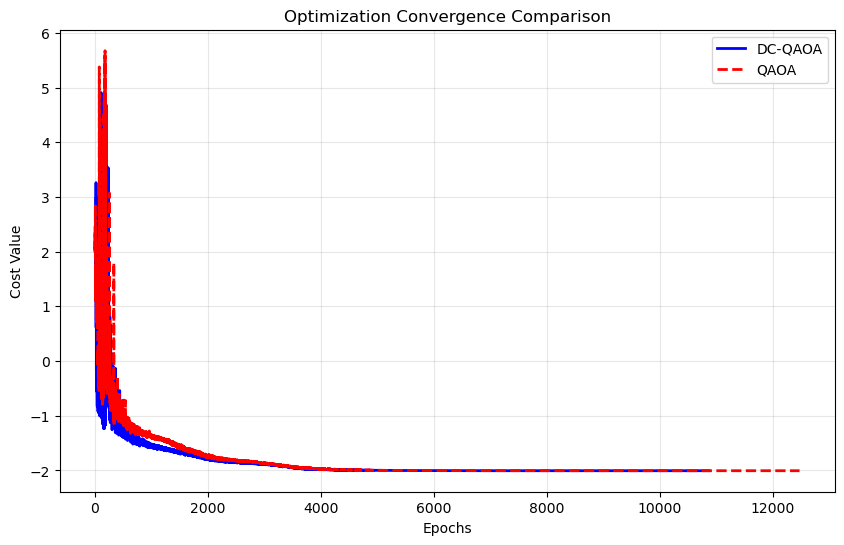


Optimization Summary:
DC-QAOA: 10874 iterations, final cost: -2.005709
QAOA: 12480 iterations, final cost: -2.005774


In [13]:
# Plot convergence comparison
plt.figure(figsize=(10, 6))

# Plot DC-QAOA trajectory
x_values_dc = list(range(len(cost_values_dc_qaoa)))
plt.plot(x_values_dc, cost_values_dc_qaoa, 'b-', label='DC-QAOA', linewidth=2)

# Plot QAOA trajectory
x_values_qaoa = list(range(len(cost_values_qaoa)))
plt.plot(x_values_qaoa, cost_values_qaoa, 'r--', label='QAOA', linewidth=2)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.title("Optimization Convergence Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print comparison statistics
print(f"\nOptimization Summary:")
print(f"DC-QAOA: {len(cost_values_dc_qaoa)} iterations, final cost: {cost_values_dc_qaoa[-1]:.6f}")
print(f"QAOA: {len(cost_values_qaoa)} iterations, final cost: {cost_values_qaoa[-1]:.6f}")